In [1]:
import numpy as np
import os
import polars as pl
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# ==========================================
# Data Loading & Preparation
# ==========================================
encoder = LabelEncoder()

def load_data(filename):
    path = os.path.join("../data", "tabular", filename)
    data = pl.read_csv(path).to_numpy()
    X = data[:, :-1].astype(float)
    y = data[:, -1]
    y_encoded = encoder.fit_transform(y)
    return X, y_encoded

try:
    X_train, y_train = load_data("train_processed.csv")
    X_val, y_val = load_data("validation_processed.csv")
    X_test, y_test = load_data("test_processed.csv")
    print(f"Data loaded successfully:\nTrain shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
except FileNotFoundError:
    print("Error: CSV for train and/or test not found! Please ensure their existence in this universe!")

Data loaded successfully:
Train shape: (2791, 106), Validation shape: (699, 106), Test shape: (301, 106)


In [3]:
# ==========================================
# SVM Training Model
# ==========================================

def linear_kernel(X):
    return X @ X.T

def soft_margin_svm(X, y, C):
    n, d = X.shape
    K = linear_kernel(X)

    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n))

    G = matrix(np.vstack([
        -np.eye(n),
        np.eye(n)
    ]))
    h = matrix(np.hstack([
        np.zeros(n),
        C * np.ones(n)
    ]))

    A = matrix(y.reshape(1, -1), tc="d")
    b = matrix(np.zeros(1))

    solvers.options["show_progress"] = False
    solution = solvers.qp(P, q, G, h, A, b)

    alpha = np.array(solution["x"]).flatten()
    return alpha

In [4]:
# ==========================================
# One vs. All Training Pipeline
# ==========================================
models = {}

C = 1.0
eps = 1e-5

for k in range(0, 5):
    print(f"Training OvA classifier for class {k}")
    y_binary = np.where(y_train == k, 1, -1)

    alpha = soft_margin_svm(X_train, y_binary, C)

    support_idx = np.where(alpha > eps)[0]
    support_vectors = X_train[support_idx]
    support_labels = y_binary[support_idx]
    support_alpha = alpha[support_idx]

    w = np.sum((support_alpha * support_labels)[:, None] * support_vectors, axis=0)

    b = np.mean(
        support_labels - support_vectors @ w
    )

    models[k] = {
        "alphas": alpha,
        "support_idx": support_idx,
        "support_vectors": support_vectors,
        "support_labels": support_labels,
        "w": w,
        "b": b
    }

Training OvA classifier for class 0
Training OvA classifier for class 1
Training OvA classifier for class 2
Training OvA classifier for class 3
Training OvA classifier for class 4


In [5]:
# ==========================================
# Analysis
# ==========================================

def distance_to_hyperplane(X, w, b):
    return (X @ w + b) / np.linalg.norm(w)

farthest_points = {}

for k in range(0, 5):
    model = models[k]
    w, b = model["w"], model["b"]

    distances = distance_to_hyperplane(X_train, w, b)

    # Data points of class k
    farthest_pos = X_train[y_train == k][
        np.argmax(distances[y_train == k])
    ]

    # Data points of all other classes
    farthest_neg = X_train[y_train != k][
        np.argmin(distances[y_train != k])
    ]

    farthest_points[k] = {
        "positive": farthest_pos,
        "negative": farthest_neg
    }


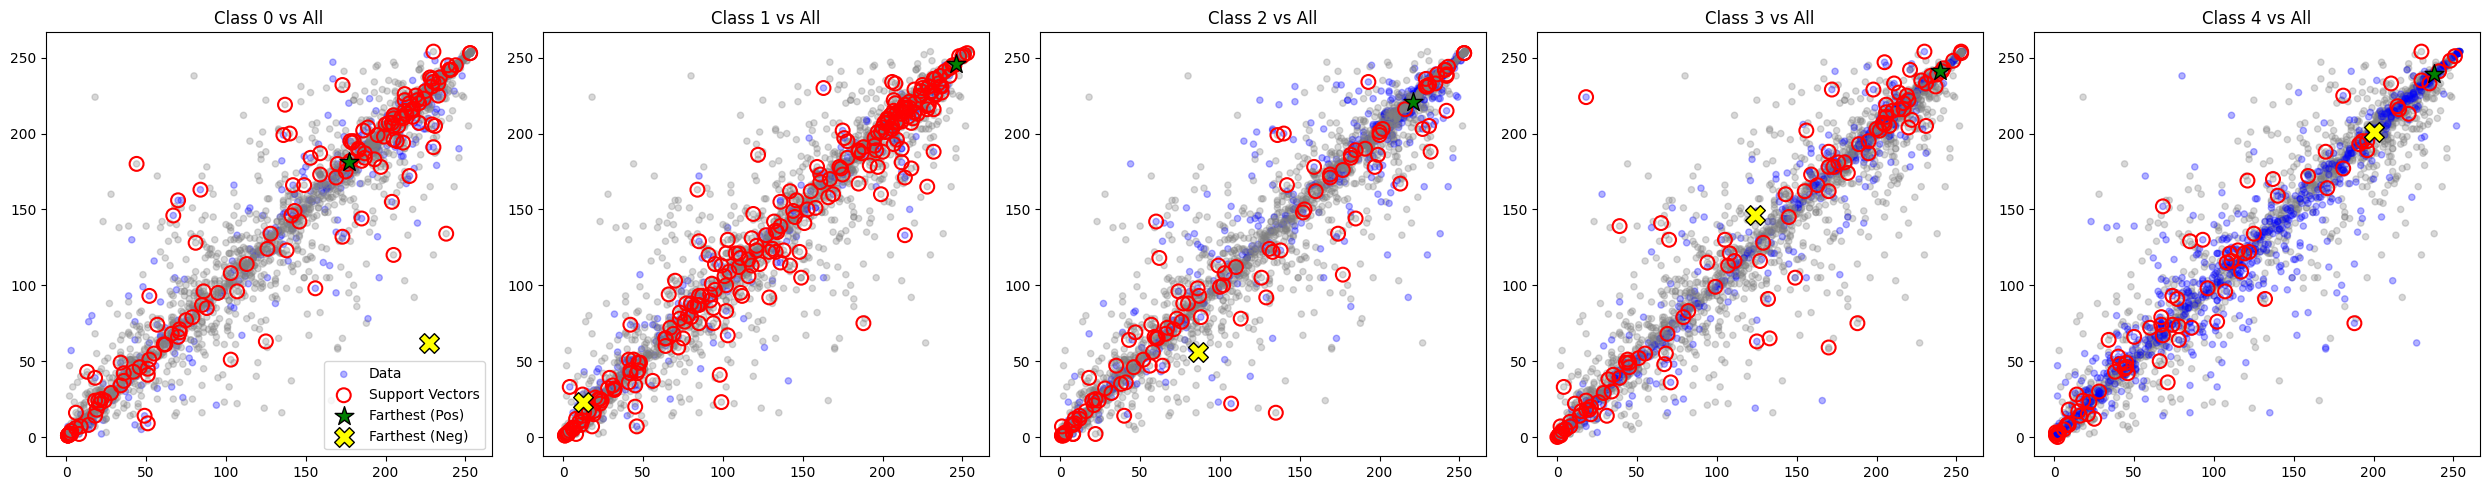

In [6]:
# ==========================================
# Plotting
# ==========================================

def plot_support_vectors_and_farthest(X, y, models, farthest_points):
    num_classes = len(models)
    
    # Create subplots to avoid opening 5 separate windows
    fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
    if num_classes == 1: axes = [axes] # Handle single class case

    for k in range(num_classes):
        ax = axes[k]
        model = models[k]
        sv = model["support_vectors"]
        
        # 1. Plot all data points (background)
        # We use a simple binary color scheme for clarity in OvA: Class k vs Rest
        colors = np.where(y == k, 'blue', 'gray')
        ax.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.3, s=20, label='Data')

        # 2. Highlight Support Vectors (Red circles)
        ax.scatter(sv[:, 0], sv[:, 1], s=100, facecolors='none', edgecolors='red', 
                   linewidth=1.5, label='Support Vectors')

        # 3. Highlight Farthest Points (Green Stars)
        fp = farthest_points[k]
        # Farthest Positive (Deep inside the class cluster)
        ax.scatter(fp['positive'][0], fp['positive'][1], s=200, marker='*', 
                   c='green', edgecolors='black', label='Farthest (Pos)')
        # Farthest Negative (Deep inside the "Rest" cluster)
        ax.scatter(fp['negative'][0], fp['negative'][1], s=200, marker='X', 
                   c='yellow', edgecolors='black', label='Farthest (Neg)')

        ax.set_title(f"Class {k} vs All")
        if k == 0: ax.legend() # Only show legend once to avoid clutter

    plt.tight_layout()
    plt.show()

# Replace your old plot call with this:
plot_support_vectors_and_farthest(X_train, y_train, models, farthest_points)

In [7]:
# ==========================================
# Pairwise Distances
# ==========================================

from itertools import combinations, product

def all_pairwise_sv_distances(models):
    results = {}

    for k1, k2 in combinations(models.keys(), 2):
        sv1 = models[k1]["support_vectors"]
        sv2 = models[k2]["support_vectors"]

        dists = [
            np.linalg.norm(a - b)
            for a, b in product(sv1, sv2)
        ]

        results[(k1, k2)] = sorted(dists)

    return results

def rank_class_confusions(pairwise_distances, top_k=5):
    ranking = []

    for (k1, k2), dists in pairwise_distances.items():
        ranking.append({
            "class_pair": (k1, k2),
            "min_distance": dists[0],
            "mean_distance": np.mean(dists[:top_k])
        })

    ranking = sorted(ranking, key=lambda x: x["min_distance"])
    return ranking


pairwise_distances = all_pairwise_sv_distances(models)

confusion_ranking = rank_class_confusions(pairwise_distances)

for r in confusion_ranking:
    print(r)


{'class_pair': (0, 1), 'min_distance': np.float64(0.0), 'mean_distance': np.float64(0.0)}
{'class_pair': (0, 2), 'min_distance': np.float64(0.0), 'mean_distance': np.float64(0.0)}
{'class_pair': (0, 3), 'min_distance': np.float64(0.0), 'mean_distance': np.float64(0.0)}
{'class_pair': (0, 4), 'min_distance': np.float64(0.0), 'mean_distance': np.float64(35.742764894816005)}
{'class_pair': (1, 2), 'min_distance': np.float64(0.0), 'mean_distance': np.float64(0.0)}
{'class_pair': (1, 3), 'min_distance': np.float64(0.0), 'mean_distance': np.float64(0.0)}
{'class_pair': (1, 4), 'min_distance': np.float64(0.0), 'mean_distance': np.float64(0.0)}
{'class_pair': (2, 3), 'min_distance': np.float64(0.0), 'mean_distance': np.float64(107.44078480904386)}
{'class_pair': (2, 4), 'min_distance': np.float64(0.0), 'mean_distance': np.float64(74.87772693979839)}
{'class_pair': (3, 4), 'min_distance': np.float64(0.0), 'mean_distance': np.float64(0.0)}


In [8]:
# Quick check as help to write the discussion part
from sklearn.metrics import confusion_matrix

print("\n--- Reference for Discussion ---")
print("Confusion Matrix (Rows=True, Cols=Pred):")

scores = np.zeros((len(X_train), 5))
for k in range(5):
    scores[:, k] = X_train @ models[k]["w"] + models[k]["b"]
y_pred_svm = np.argmax(scores, axis=1)
print(confusion_matrix(y_train, y_pred_svm))


--- Reference for Discussion ---
Confusion Matrix (Rows=True, Cols=Pred):
[[531   2   2   4   1]
 [  1 319  10   1   7]
 [  2   6 592   0   0]
 [  0   1   0 546   8]
 [  0   1   0   0 757]]


---

# Live Demo

In [9]:
# ==========================================
# Outlier Detection
# ==========================================

def detect_outliers_slack(X, y, models, top_n=5):
    """
    Identifies outliers based on margin violations (slack variables)
    """
    n_samples = X.shape[0]
    max_slacks = np.zeros(n_samples)

    for k, model in models.items():
        w = model['w']
        b = model['b']

        y_binary = np.where(y == k, 1, -1)
        margins = y_binary * (X @ w + b)
        slacks = np.maximum(0, 1 - margins)
        
        class_mask = (y == k)
        max_slacks[class_mask] = np.maximum(max_slacks[class_mask], slacks[class_mask])

    outlier_indices = np.argsort(max_slacks)[::-1][:top_n]

    return outlier_indices, max_slacks

outlier_idx, scores = detect_outliers_slack(X_train, y_train, models, top_n=5)
print("Top 5 Outlier Indices:", outlier_idx)
print("Outlier Scores:", scores[outlier_idx])

Top 5 Outlier Indices: [661 847 606 781 424]
Outlier Scores: [8.02377058 6.8445226  6.75524229 6.1869221  5.54604002]


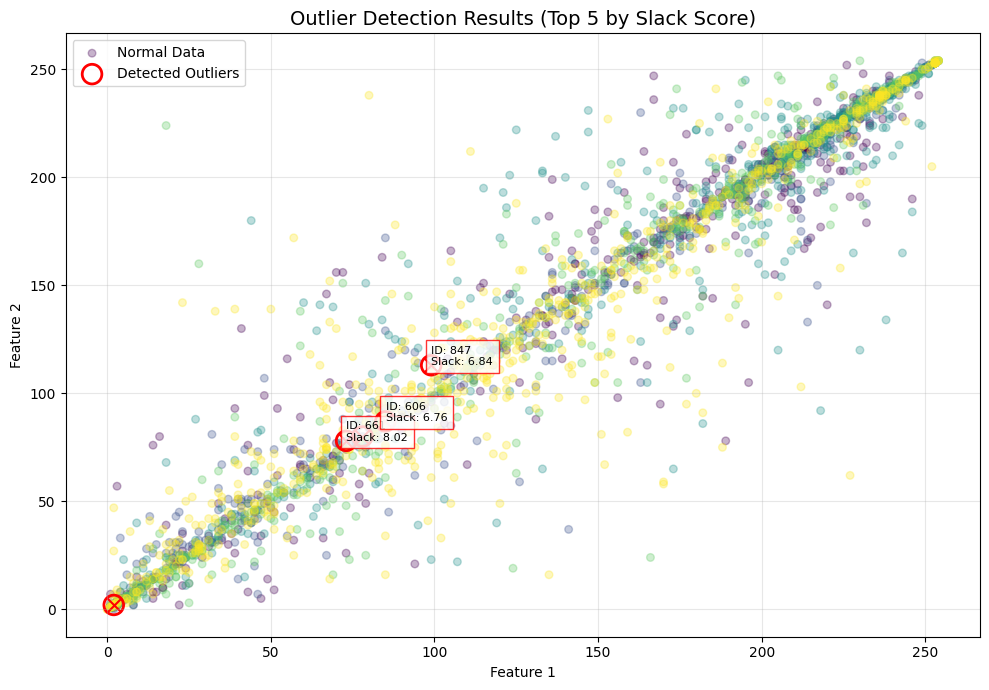

In [15]:
def plot_detected_outliers(X, y, outlier_indices, scores):
    """
    Plots the training data and highlights the top detected outliers.
    """
    plt.figure(figsize=(10, 7))
    
    # 1. Plot all normal data points (gray/dimmed)
    # We use the first two features (columns 0 and 1) for X and Y axes
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.3, s=30, label='Normal Data')
    
    # 2. Highlight the Outliers
    outlier_data = X[outlier_indices]
    outlier_labels = y[outlier_indices]
    
    # Plot outliers as big red circles with an X inside
    plt.scatter(outlier_data[:, 0], outlier_data[:, 1], 
                s=200, facecolors='none', edgecolors='red', linewidth=2, label='Detected Outliers')
    plt.scatter(outlier_data[:, 0], outlier_data[:, 1], 
                s=100, marker='x', c='red')

    # 3. Annotate the top 3 outliers with their ID and Score
    for i in range(min(3, len(outlier_indices))):
        idx = outlier_indices[i]
        score = scores[idx]
        px, py = X[idx, 0], X[idx, 1]
        
        plt.text(px + 0.05, py + 0.05, f"ID: {idx}\nSlack: {score:.2f}", 
                 fontsize=8, bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

    plt.title(f"Outlier Detection Results (Top {len(outlier_indices)} by Slack Score)", fontsize=14)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run it with the variables from your previous step
# Assume 'outlier_idx' and 'all_scores' come from the detection function I gave you earlier
plot_detected_outliers(X_train, y_train, outlier_idx, scores)